In [ ]:
# !pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.


In [2]:
from datasets import load_dataset
import tqdm as notebook_tqdm
# FB15k-237 from HuggingFace
dataset = load_dataset("VLyb/FB15k-237")

train_triples = dataset["train"]
test_triples = dataset["test"]
valid_triples = dataset["validation"]
print(train_triples[0])

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

valid.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/272115 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/17535 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20466 [00:00<?, ? examples/s]

{'head': '/m/027rn', 'relation': '/m/06cx9', 'tail': '/location/country/form_of_government'}


In [6]:
print(train_triples[0])
print(train_triples[1])
print(train_triples[2])

{'head': '/m/027rn', 'relation': '/m/06cx9', 'tail': '/location/country/form_of_government'}
{'head': '/m/017dcd', 'relation': '/m/06v8s0', 'tail': '/tv/tv_program/regular_cast./tv/regular_tv_appearance/actor'}
{'head': '/m/07s9rl0', 'relation': '/m/0170z3', 'tail': '/media_common/netflix_genre/titles'}


As we see here it looks like the relation and tail are inverted. This makes the evaluation of model performance meaningless if it is not corrected. Therefore we will fix it in the following way:

In [4]:
def fix_fields(example):
    return {
        "head": example["head"],
        "relation": example["tail"],
        "tail": example["relation"]
    }

train_dataset = dataset["train"].map(fix_fields)
valid_dataset = dataset["validation"].map(fix_fields)
test_dataset  = dataset["test"].map(fix_fields)



Map:   0%|          | 0/272115 [00:00<?, ? examples/s]

Map:   0%|          | 0/17535 [00:00<?, ? examples/s]

Map:   0%|          | 0/20466 [00:00<?, ? examples/s]

In [7]:
train_triples = train_dataset.select(range(10000))
valid_triples = valid_dataset.select(range(2000))
test_triples  = test_dataset.select(range(2000))

In [8]:
print(train_triples[0])
print(train_triples[1])
print(train_triples[2])

{'head': '/m/027rn', 'relation': '/location/country/form_of_government', 'tail': '/m/06cx9'}
{'head': '/m/017dcd', 'relation': '/tv/tv_program/regular_cast./tv/regular_tv_appearance/actor', 'tail': '/m/06v8s0'}
{'head': '/m/07s9rl0', 'relation': '/media_common/netflix_genre/titles', 'tail': '/m/0170z3'}


In [9]:
# use only a subset of the data. This is done as my laptop does not have a GPU and therfore struggles
subset_size = 10000

train_triples = train_triples.select(range(subset_size))
valid_triples = valid_triples.select(range(2000))
test_triples = test_triples.select(range(2000))

* load the mapping of entities and relations

In [10]:
!wget https://raw.githubusercontent.com/yao8839836/kg-bert/master/data/FB15k-237/entity2text.txt
!wget https://raw.githubusercontent.com/yao8839836/kg-bert/master/data/FB15k-237/relation2text.txt

# Load entity names
entity_map = {}
with open("entity2text.txt", encoding="utf-8") as f:
    for line in f:
        eid, name = line.strip().split('\t')
        entity_map[eid] = name

# Load relation names
relation_map = {}
with open("relation2text.txt", encoding="utf-8") as f:
    for line in f:
        rid, name = line.strip().split('\t')
        relation_map[rid] = name


def triple_to_sentence(h, r, t, entity_map = entity_map, relation_map = relation_map):
    h_text = entity_map.get(h, h)
    r_text = relation_map.get(r, r.replace("/", " ").replace("_", " "))
    t_text = entity_map.get(t, t)
    return f"{h_text} {r_text} {t_text}."

--2025-07-26 19:27:42--  https://raw.githubusercontent.com/yao8839836/kg-bert/master/data/FB15k-237/entity2text.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392383 (383K) [text/plain]
Saving to: ‘entity2text.txt’

entity2text.txt     100%[===================>] 383.19K  --.-KB/s    in 0.006s  

2025-07-26 19:27:42 (63.6 MB/s) - ‘entity2text.txt’ saved [392383/392383]

--2025-07-26 19:27:42--  https://raw.githubusercontent.com/yao8839836/kg-bert/master/data/FB15k-237/relation2text.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [11]:
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer -- ModernBERT
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base", trust_remote_code=True)
model = AutoModel.from_pretrained("answerdotai/ModernBERT-base", trust_remote_code=True)
model.eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

2025-07-26 19:28:09.264207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753558089.542742      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753558089.628560      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

ModernBertModel(
  (embeddings): ModernBertEmbeddings(
    (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
  (layers): ModuleList(
    (0): ModernBertEncoderLayer(
      (attn_norm): Identity()
      (attn): ModernBertAttention(
        (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
        (rotary_emb): ModernBertRotaryEmbedding()
        (Wo): Linear(in_features=768, out_features=768, bias=False)
        (out_drop): Identity()
      )
      (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): ModernBertMLP(
        (Wi): Linear(in_features=768, out_features=2304, bias=False)
        (act): GELUActivation()
        (drop): Dropout(p=0.0, inplace=False)
        (Wo): Linear(in_features=1152, out_features=768, bias=False)
      )
    )
    (1-21): 21 x ModernBertEncoderLayer(
      (attn_norm): LayerNorm((768,), eps=1e-05, e

In [13]:
import torch

# score a sentence -- we would like a higher positive or negative score dependinf on the sentence

@torch.no_grad()
def score_sentence(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    score = torch.norm(cls_embedding, p=2, dim=1)
    return score.item()


In [14]:
# get a set containing all the entities in any of the three sets
all_entities = set()

for split in [train_triples, test_triples, valid_triples]:
    for row in split:
        all_entities.update([row["head"], row["tail"]])
all_entities = list(all_entities)


In [15]:
import random

# corrupt either the head or the tail
def corrupt_triple(triple, entity_list):
    head, relation, tail = triple
    if random.random() < 0.5:
        # Corrupt tail
        corrupted = (head, relation, random.choice(entity_list))
    else:
        # Corrupt head
        corrupted = (random.choice(entity_list), relation, tail)
    return corrupted

In [16]:
# Pick a positive triple
pos = test_triples[0]
pos_triple = (pos["head"], pos["relation"], pos["tail"])

# Corrupt it
neg_triple = corrupt_triple(pos_triple, all_entities)

# Convert to sentences
pos_sentence = triple_to_sentence(*pos_triple, entity_map, relation_map)
neg_sentence = triple_to_sentence(*neg_triple, entity_map, relation_map)

# Score both
pos_score = score_sentence(pos_sentence)
neg_score = score_sentence(neg_sentence)

print(f"Positive score: {pos_score:.4f}")
print(f"Negative score: {neg_score:.4f}")

Positive score: 36.1393
Negative score: 36.1106


using bert alone, with a basic loss function and no training shows that the model is not attuned enough to this type of task and the difference between positive (indicating that the triple is correct) and negative (triple is incorrect) scores is too mild for it to be acceptable. Therefore some steps need to be taken in order to make it better


- build a dataset which contains the triples labelled (corrupted or not)


In [17]:
# check that the lenght of the triples is correct
len(train_triples)

10000

In [18]:
train_triples[0]

{'head': '/m/027rn',
 'relation': '/location/country/form_of_government',
 'tail': '/m/06cx9'}

Since we are using modernbert, the entities and relations need to make sense to be able to use its pretraining

In [19]:
import random

# corrupt either the head or the tail
def corrupt_triple2(triple, entity_list):
    h, r, t = triple['head'], triple['relation'], triple['tail']
    if random.random() < 0.5:
        corrupted = (random.choice(entity_list), r, t)
    else:
        corrupted = (h, r, random.choice(entity_list))
    return corrupted

In [20]:
def make_labeled_data(triples, all_entities, corrupt_fn, entity_map, relation_map):
    data = []
    for triple in triples:
        h, r, t = triple["head"], triple["relation"], triple["tail"]
        pos_sentence = triple_to_sentence(h, r, t, entity_map, relation_map)
        data.append((pos_sentence, 1))

        ch, cr, ct = corrupt_fn(triple, all_entities)
        neg_sentence = triple_to_sentence(ch, cr, ct, entity_map, relation_map)
        data.append((neg_sentence, 0))
    return data

# create the proper data to train, validate and test the model
# each is going to contain double the data they start with as for every triple we have a positive and a negative
train_data = make_labeled_data(train_triples, all_entities, corrupt_triple2, entity_map, relation_map)
val_data = make_labeled_data(valid_triples, all_entities, corrupt_triple2, entity_map, relation_map)
test_data = make_labeled_data(test_triples, all_entities, corrupt_triple2, entity_map, relation_map)


In [21]:
# tokenize the data
def tokenize_data(data):
    tokenized = []
    for sentence, label in data:
        encoded = tokenizer(sentence, truncation=True, padding='max_length', max_length=32, return_tensors='pt')
        tokenized.append({
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.float)
        })
    return tokenized

train_tokenized = tokenize_data(train_data)
val_tokenized = tokenize_data(val_data)
test_tokenized = tokenize_data(test_data)


- create a torch dataset

In [ ]:
# tokenized_data = []
# for sentence, label in data:
#     enc = tokenizer(
#         sentence,
#         truncation=True,
#         padding="max_length",
#         max_length=32,
#         return_tensors="pt"
#     )
#     tokenized_data.append({
#         "input_ids": enc["input_ids"].squeeze(0),
#         "attention_mask": enc["attention_mask"].squeeze(0),
#         "label": torch.tensor(label, dtype=torch.float)
#     })

In [25]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base", trust_remote_code=True)

In [26]:
def collate_fn(batch):
    return {
        "input_ids": torch.stack([item["input_ids"] for item in batch]),
        "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
        "label": torch.stack([item["label"] for item in batch])
    }

In [27]:
from torch.utils.data import Dataset, DataLoader

class PreTokenizedDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]

train_loader = DataLoader(PreTokenizedDataset(train_tokenized), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(PreTokenizedDataset(val_tokenized), batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(PreTokenizedDataset(test_tokenized), batch_size=32, collate_fn=collate_fn)



- add classification head

In [28]:
import torch.nn as nn
from transformers import AutoModel

class TripleClassifier(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.encoder = base_model
        self.classifier = nn.Linear(base_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls).squeeze(-1)
        return logits



In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = AutoModel.from_pretrained("answerdotai/ModernBERT-base", trust_remote_code=True)
model = TripleClassifier(base_model)
model.to(device)
print(next(model.parameters()).device)

cuda:0


- train the model

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()
model.train()

TripleClassifier(
  (encoder): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      )
      (1-21): 2

- this is not good, let us try to use train and validation

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=2e-1)
# criterion = nn.BCEWithLogitsLoss()

In [31]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_examples = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            total_correct += (preds == labels).sum().item()
            total_examples += labels.size(0)

    model.train()
    accuracy = total_correct / total_examples
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy


In [34]:
print(next(iter(train_loader))["input_ids"].device)

cpu


In [37]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [38]:
for epoch in range(5):
    total_train_loss = 0
    total_train_correct = 0
    total_train_examples = 0
    model.train()

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        total_train_correct += (preds == labels).sum().item()
        total_train_examples += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = total_train_correct / total_train_examples

    avg_val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


W0726 19:32:18.208000 36 torch/_dynamo/convert_frame.py:1233] WON'T CONVERT compiled_embeddings /usr/local/lib/python3.11/dist-packages/transformers/models/modernbert/modeling_modernbert.py line 204 
W0726 19:32:18.208000 36 torch/_dynamo/convert_frame.py:1233] due to: 
W0726 19:32:18.208000 36 torch/_dynamo/convert_frame.py:1233] Traceback (most recent call last):
W0726 19:32:18.208000 36 torch/_dynamo/convert_frame.py:1233]   File "/usr/local/lib/python3.11/dist-packages/torch/_dynamo/convert_frame.py", line 1164, in __call__
W0726 19:32:18.208000 36 torch/_dynamo/convert_frame.py:1233]     result = self._inner_convert(
W0726 19:32:18.208000 36 torch/_dynamo/convert_frame.py:1233]              ^^^^^^^^^^^^^^^^^^^^
W0726 19:32:18.208000 36 torch/_dynamo/convert_frame.py:1233]   File "/usr/local/lib/python3.11/dist-packages/torch/_dynamo/convert_frame.py", line 547, in __call__
W0726 19:32:18.208000 36 torch/_dynamo/convert_frame.py:1233]     return _compile(
W0726 19:32:18.208000 36 t

Epoch 1 | Train Loss: 0.6965 | Train Acc: 0.5186 | Val Loss: 0.6909 | Val Acc: 0.5415
Epoch 2 | Train Loss: 0.6588 | Train Acc: 0.5916 | Val Loss: 0.5554 | Val Acc: 0.7318
Epoch 3 | Train Loss: 0.4586 | Train Acc: 0.7833 | Val Loss: 0.3873 | Val Acc: 0.8320
Epoch 4 | Train Loss: 0.3113 | Train Acc: 0.8689 | Val Loss: 0.3119 | Val Acc: 0.8705
Epoch 5 | Train Loss: 0.2329 | Train Acc: 0.9084 | Val Loss: 0.3129 | Val Acc: 0.8718


In [39]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


Test Loss: 0.3238 | Test Accuracy: 0.8678


In [40]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend((probs > 0.5).float().cpu().numpy())


In [41]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.9075    0.8190    0.8610      2000
         1.0     0.8351    0.9165    0.8739      2000

    accuracy                         0.8678      4000
   macro avg     0.8713    0.8678    0.8674      4000
weighted avg     0.8713    0.8678    0.8674      4000



In [42]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(all_labels, all_probs)
print(f"ROC AUC: {auc:.4f}")

ROC AUC: 0.9259


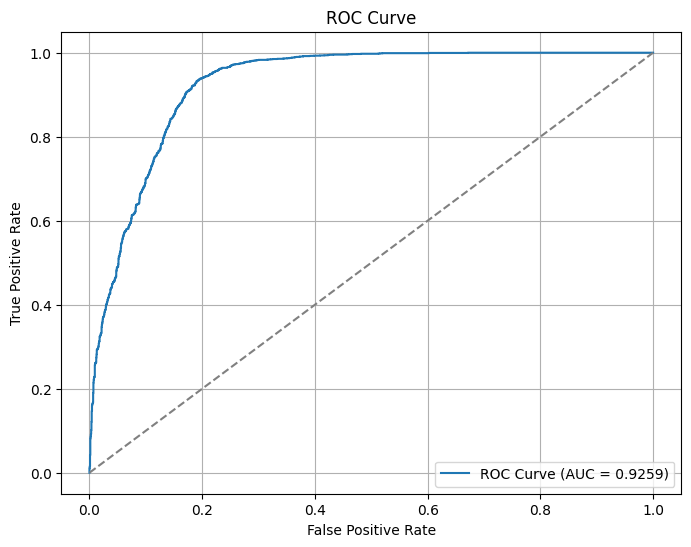

In [43]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


**Analysis of results**:

These seem to be quite high, especially for a binary classification task and therefore we are brought to ask ourselves the question wether this is a little too good to be true.

Still, I would like to propose the following reasons as to why this might be happening:


*   Having corrupted relations instead of proper negative ones makes for an easier task to complete for the model, which means that we would generally expect a higher test accuracy
* Having well-formed inputs with BERT encoders (like we have here with the mapping of entities and relations) takes advantage of the pretraining, and therefore makes the task easier
*   The patterns of positive and negative examples are fairly similar, meaning that the model learns in a much smoother way



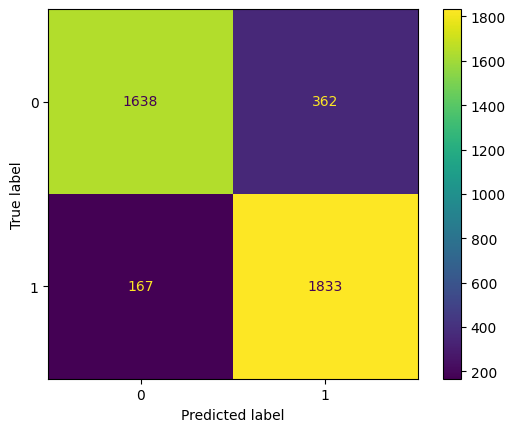

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

**Possible next steps**

A good idea would be to see if we can further corrupt the triples in a much more disordered way, for example mixing up entities and relations or even adding noise to see how well the model performs. I could also show that without actual phrases so if the model sees gibberish it performs really badly, this could be something to add.